# Axial pile response in SANDS

Tutorial notebook to run pile response analysis through OpenSees assuming the **new unified CPT-based method** ([Lehane et al. 2020](https://doi.org/10.1680/jgele.20.00096)) for driven piles in sands. 

The axial curves to simulate the load-displacement response of driven piles in sands were included through two new materials:
- ```TzSandCPT``` for the shaft load transfer function
- ```QbSandCPT``` for the end bearing load transfer function


*LAST MODIFICATION:* **19/02/2024**
*****

This DDL is only compatible with ```python 3.8```

In [1]:
from platform import python_version
print(python_version())

3.8.5


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# DLL import 
import opensees as ops 

## 1. Inputs

The input data is based on the EURIPIDES worked example from ([Jardine, 2005](https://www.researchgate.net/publication/266276027_ICP_design_methods_for_driven_piles_in_sands_and_clays)). Both, pile and soil inputs are obtained from the **Table B2** presented in *Appendix B*.

### Soil data

CPT and effective vertical unit weight profiles as deined in **Table B2** are imported from an Excel spreadsheet as a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [3]:
path = 'Inputs/TableB2bis.xlsx'
soil_data = pd.read_excel(path)
soil_data['qc [kPa]'] = soil_data['qc [MPa]']*1e3 
soil_data.head()

,z [m],dz [m],Sv [kPa],qc [MPa],qc [kPa]
0,0.0,0.5,0,0.0,0.0
1,1.0,1.0,16,5.0,5000.0
2,2.0,1.0,31,9.0,9000.0
3,3.0,1.0,47,10.0,10000.0
4,4.0,1.0,62,10.0,10000.0


In [4]:
print('Pile length as imported={:.1f} m'.format(soil_data['dz [m]'].sum()))

Pile length as imported=47.0 m


Let's plot the retained soil profile

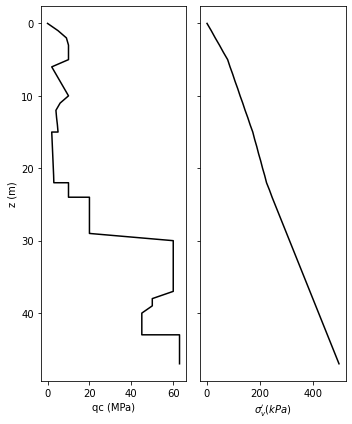

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 6))

ax1.plot(soil_data['qc [MPa]'], soil_data['z [m]'], 'k')
ax1.invert_yaxis()
ax1.set_xlabel('qc (MPa)')
ax1.set_ylabel('z (m)')

ax2.plot(soil_data['Sv [kPa]'], soil_data['z [m]'], 'k')


ax2.set_xlabel(r'$\sigma_v^{\prime} (kPa)$')

fig.tight_layout()

An estimate for the end bearing capacity mobilised at large displacements at the pile tip ($q_p$) is required.

In [6]:
qp = 63e3              # (kPa)

Nominal values for other method parameters

In [7]:
DCPT_DEFAULT = 35.7e-3  # CPT diameter probe (m)
PA_DEFAULT = 100.       # atmospheric pressure (kPa)

### Pile data

Pile geometry parameters are assumed as defined in Table B2: 

- pile diameter $D$=0.763 m 
- pile length $L$=47 m
- pile wall thickness $t_w$=36mm

In [8]:
L = 47.                # pile length (m)
D = 0.763              # pile diameter (m)
t = 36e-3              # pile wall thickness (m)

Mechanical properties, a Young's modulus of 210 GPa is assumed for the steel.

In [9]:
E = 210e6  # kPa
r2 = D/2; r1 = r2 - t
A = np.pi * (np.power(r2, 2) - np.power(r1, 2))      # pile cross section area [m2]
I = np.pi / 4 * (np.power(r2, 4) - np.power(r1, 4))  # moment of inertia [m4]

## 2. FE model 

#### Model definition

For this example, a 2D model (x, z) with three translational degrees-of-freedom is sufficient. 

In [10]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

#### Mesh 

The mesh is defined by the number of elements specified in the pile. In this example, this would be defined by the discretization step of 1 assumed for the soil profile. Therefore, there are 53 nodes and 52 elements as shown below.

- pile nodes coordinates are defined by the depth values of the assumed CPT profile
- tag of pile head node is 0 and tag pile tip is 52.
- soil spring nodes are defined according to [this example](https://opensees.berkeley.edu/wiki/index.php/Laterally-Loaded_Pile_Foundation).
- pile nodes are linked to the "slave" spring nodes using the **equalDOF** command.

In [11]:
print('Number of pile nodes = {}'.format(soil_data.shape[0]))

Number of pile nodes = 53


In [12]:
TAG_HEAD = soil_data.index[0]
TAG_TOE = soil_data.index[-1]

In [13]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)
# 
for tag, row in soil_data.iterrows():
    # Pile node
    ops.node(tag, 0., -row['z [m]'])
    # Slave node - soil spring
    ops.node(tag+1000, 0., -row['z [m]'])
    ops.fix(tag+1000, 1, 0, 1)
    # Fixed node - end soil spring
    ops.node(tag+2000, 0., -row['z [m]'])
    ops.fix(tag+2000, 1, 1, 1)
    # Linking pile nodes with soil nodes
    ops.equalDOF(tag, tag+1000, 2)

Nodes for end bearing soil spring

In [14]:
# Slave node - soil spring
tag = soil_data.index[-1]+3000
ops.node(tag, 0., -row['z [m]'])
ops.fix(tag, 1, 0, 1)
# Fixed node - end soil spring
tag = soil_data.index[-1]+4000
ops.node(tag, 0., -row['z [m]'])
ops.fix(tag, 1, 1, 1)
# Linking pile nodes with soil nodes
tag = soil_data.index[-1]
ops.equalDOF(tag, tag+3000, 2)

In [15]:
TAG_QZ = tag+3000
print('Tag constrained node Q-z spring {}'.format(tag+3000))

Tag constrained node Q-z spring 3052


#### Pile elements

Euler-Bernouilli beam elements to discretize the pile

In [16]:
transf_tag = 1
ops.geomTransf('Linear', transf_tag) 
for tag, row in soil_data.iterrows():
    if tag != soil_data.index[-1]:
        ops.element('elasticBeamColumn', tag, tag, tag+1, A, E, I, transf_tag)

#### t-z springs 

Shaft load transfer functions for sands according to the new unified CPT-based method.

**NOTE**: by default the material assumes an ultimate interface friction angle of 29º unless other values is passed by the user.

In [17]:
for tag, row in soil_data.iterrows():
    # Creating material to simulate shaft load transfer function
    ops.uniaxialMaterial('TzSandCPT',
                         tag+1000,
                         row["qc [kPa]"],
                         row["Sv [kPa]"],
                         D,
                         t,
                         L - row["z [m]"],
                         row["dz [m]"],
                         DCPT_DEFAULT,
                         PA_DEFAULT
                         )
    # t-z curve
    ops.element('zeroLength', tag+1000, tag+1000, tag+2000, '-mat', tag+1000, '-dir', 2)

#### Q-z springs

End bering load transfer function for sands according to the new unified CPT-based method.

In [18]:
# Creating material to simulate end bearing transfer function
tag = soil_data.index[-1]+ 3000
ops.uniaxialMaterial('QbSandCPT',
                     tag,
                     qp,
                     D,
                     t,
                     DCPT_DEFAULT
                     )
# Q-z curve
ops.element('zeroLength', tag, tag, tag+1000, '-mat', tag, '-dir', 2)

Model info can be visualized as follows.

In [19]:
#ops.printModel()

## 3. FE analysis

Diplacement controlled static analysis

### Compresssion

Negative displacement for settlement should be passed according to our reference system

In [20]:
# Create a Plain load pattern with a Linear TimeSeries
ops.timeSeries('Linear', 1) 
ops.pattern('Plain', 1, 1)
ops.load(0, 0, 1, 0)

In [21]:
ops.wipeAnalysis()
ops.constraints("Transformation")
# 2. numberer
ops.numberer("RCM")
# 3. system
ops.system("SparseGeneral")
# 4. test
ops.test("NormDispIncr", 1e-6, 25, 0)
# 5. algorithm
ops.algorithm("Newton")
# 6. integrator
dU = -0.001  # Displacement increment (1mm)
ops.integrator('DisplacementControl', 0, 2, dU, 1, dU, dU)
# 7. analysis
ops.analysis("Static")

Running static analysis until plasticity will be reached

In [22]:
TOL = 1e-4  # tolerance 
head_load = []; head_disp = []; toe_disp = []; toe_load = []
ok = 2
delta = 1.
while abs(delta) >= TOL:
    ok = ops.analyze(1)
    # Calculating displacement difference between two latest steps
    try:
        delta = ops.getLoadFactor(1)- head_load[-1]
    except IndexError:
        pass
    # Saving outputs
    head_load.append(ops.getLoadFactor(1))
    head_disp.append(ops.nodeDisp(TAG_HEAD, 2))
    toe_disp.append(ops.nodeDisp(TAG_TOE, 2))
    ops.reactions()
    toe_load.append(ops.nodeReaction(TAG_QZ, 2))
# Converting to numpy array stored outputs
head_disp = np.array(head_disp); toe_disp = np.array(toe_disp) 
head_load = np.array(head_load); toe_load = np.array(toe_load)

**Plot**

Back-bone curve at pile head and simulated end bearing

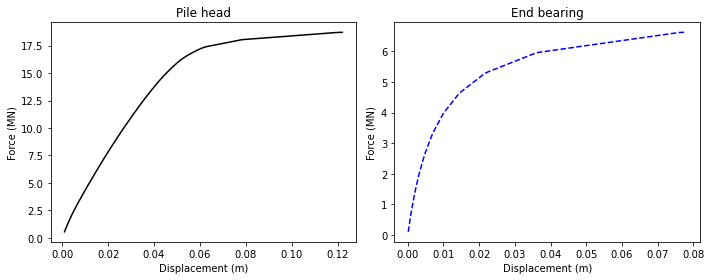

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(np.abs(head_disp), np.abs(head_load)*1e-3, 'k')
ax1.set_ylabel('Force (MN)')
ax1.set_xlabel('Displacement (m)')
ax1.set_title('Pile head')

ax2.plot(np.abs(toe_disp), np.abs(toe_load)*1e-3, 'b--')
ax2.set_ylabel('Force (MN)')
ax2.set_xlabel('Displacement (m)')
ax2.set_title('End bearing')

fig.tight_layout()

##### Computed capacities

The estimated capacities are as follows.

In [24]:
Qt = np.abs(head_load).max()*1e-3  # total capacity in compression (MN)
Qb = np.abs(toe_load).max()*1e-3   # base or end bearing capacity (MN)
Qs = Qt - Qb                       # shaft capacity 
print('Total axial capacity (compression) = {:.2f} MN'.format(Qt))
print('Shaft capacity (compression) = {:.2f} MN'.format(Qs))
print('End bearing capacity (compression) = {:.2f} MN'.format(Qb))

Total axial capacity (compression) = 18.70 MN
Shaft capacity (compression) = 12.08 MN
End bearing capacity (compression) = 6.62 MN


The computed axial capacity under compression is 18.70 MN, a similar value of 19.58 MN is reported for this example following the ICP design method. Both approaches are demed to produce similar esimates, in terms of inputs we've considered the same assumptions but the interface friction angles reported.

**TO CHECK**

The method assumes that shaft capacity in tension is equalt to 75% of the shaft compression capacity. If the method and modeling are used correctly, we should find the following capactity estimate when running the analysis for tension loading (end bearing should be 0).

In [25]:
print('Tension capacity should be about of {:.2f} MN'.format(0.75 * Qs))

Tension capacity should be about of 9.06 MN


### Tension

Positive displacement for tension loading should be passed according to our reference system

In [26]:
ops.reset()
ops.wipeAnalysis()
ops.constraints("Transformation")
# 2. numberer
ops.numberer("RCM")
# 3. system
ops.system("SparseGeneral")
# 4. test
ops.test("NormDispIncr", 1e-6, 25, 0)
# 5. algorithm
ops.algorithm("Newton")
# 6. integrator
dU = 0.001  # Displacement increment (1mm)
ops.integrator('DisplacementControl', 0, 2, dU, 1, dU, dU)
# 7. analysis
ops.analysis("Static")

In [27]:
TOL = 1e-4  # tolerance 
head_load_T = []; head_disp_T = []; toe_disp_T = []; toe_load_T = []
delta = 1.
while abs(delta) >= TOL:
    ok = ops.analyze(1)
    # Calculating displacement difference between two latest steps
    try:
        delta = ops.getLoadFactor(1)- head_load_T[-1]
    except IndexError:
        pass
    # Saving outputs
    head_load_T.append(ops.getLoadFactor(1))
    head_disp_T.append(ops.nodeDisp(TAG_HEAD, 2))
    toe_disp_T.append(ops.nodeDisp(TAG_TOE, 2))
    ops.reactions()
    toe_load_T.append(ops.nodeReaction(TAG_QZ, 2))
# Converting to numpy array stored outputs
head_disp_T = np.array(head_disp_T); toe_disp_T = np.array(toe_disp_T) 
head_load_T = np.array(head_load_T); toe_load_T = np.array(toe_load_T)

Plot

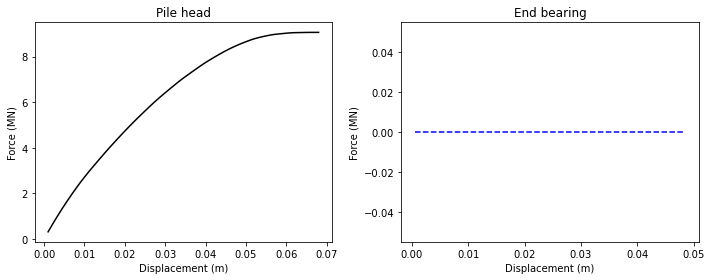

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(np.abs(head_disp_T), np.abs(head_load_T)*1e-3, 'k')
ax1.set_ylabel('Force (MN)')
ax1.set_xlabel('Displacement (m)')
ax1.set_title('Pile head')

ax2.plot(np.abs(toe_disp_T), np.abs(toe_load_T)*1e-3, 'b--')
ax2.set_ylabel('Force (MN)')
ax2.set_xlabel('Displacement (m)')
ax2.set_title('End bearing')

fig.tight_layout()

##### Computed capacities

The estimated capacities are as follows.

In [29]:
Qt_T = np.abs(head_load_T).max()*1e-3  # total capacity in compression (MN)
Qb_T = np.abs(toe_load_T).max()*1e-3   # base or end bearing capacity (MN)
Qs_T = Qt_T - Qb_T                     # shaft capacity 
print('Total axial capacity (tension) = {:.2f} MN'.format(Qt_T))
print('Shaft capacity (tension) = {:.2f} MN'.format(Qs_T))
print('End bearing capacity (tension) = {:.2f} MN'.format(Qb_T))

Total axial capacity (tension) = 9.06 MN
Shaft capacity (tension) = 9.06 MN
End bearing capacity (tension) = 0.00 MN


**:)**